# Résumé

## Imports

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity as cos_sim
from sklearn.preprocessing import normalize
from collections import defaultdict

import xml.sax as sax
from xml.sax import SAXParseException

import os
import numpy as np
import re
import nltk
from math import log

from nltk.tokenize import sent_tokenize
from pprint import pprint as pp

from IPython.core.display import display, HTML

from IPython.display import clear_output
clear_output()

### Lecteur HTML 

In [ ]:
class TextHandler(sax.ContentHandler):
    
    def __init__(self) :
        self._activeParse = False
        self._result = ""
    
    def startDocument(self):
        pass

    def startElement(self, name, attrs):
        if name in {"TEXT", "LEADPARA"}:
            self._activeParse = True

    def endElement(self, name):
        if name in {"TEXT", "LEADPARA"} :
            self._activeParse = False

    def characters(self, content):
        if self._activeParse :
            self._result += content.replace('\n'," ")

In [ ]:
class ResumeHandler(sax.ContentHandler):
    
    def __init__(self) :
        self._activeParse = False
        self._charBuffer = ""
        self._active_doc = ""
        self._result = []
    
    def startDocument(self):
        pass

    def startElement(self, name, attrs):
        if name == "SUM" :
            self._activeParse = True
            self._active_doc = attrs["DOCREF"].strip(" ")
            self._charBuffer = ""

    def endElement(self, name):
        if name == "SUM" :
            self._activeParse = False
            self._result.append((self._active_doc, self._charBuffer))
            

    def characters(self, content):
        if self._activeParse :
            self._charBuffer += content.replace('\n'," ")

In [ ]:
def parse_file(file, handler) :
    try :
        sax.parse(open(file, encoding = 'utf-8'), handler)
        return handler._result
    except SAXParseException as e:
        print(file,"contains some errors")
        return None

## Fonctions de similarité et Algo TextRank 

In [ ]:
def generate_sim_bow(corpus) :
    sent_words = [] 
    for sent in corpus :
        sent_words.append(set(sent.split(" ")))
    sim = [ [0 for i in range(len(corpus))] for i in range(len(corpus)) ]
    for i in range(len(corpus)) :
        for j in range(i+1,len(corpus)) :
            k = (len(sent_words[i].intersection(sent_words[j]))
                / (log(len(corpus[i].split(" "))) + log(len(corpus[j].split(" ")))))
            sim[i][j] = k
            sim[j][i] = k
    return sim

def tfidf_matrix(corpus) :
    #vectorizer = TfidfVectorizer()
    X = tfidf_vectorizer.transform(corpus)
    return cos_sim(X, X)


In [ ]:
def pagerank(A, eps=0.0001, d=0.85, max_iter = 5000):
    P = np.ones(len(A)) / len(A)
    while max_iter :
        max_iter-=1
        new_P = np.ones(len(A)) * (1 - d)/ len(A) + d * A.dot(P)
        delta = abs(new_P - P).sum()
        if delta <= eps:
            return new_P
        P = new_P
    print("Convergence error")
    return new_P

### Zone de bricole

In [ ]:
def tokenizer_cleaner(corpus) :
    docs = {}
    for key, sents in corpus.items() :
        sentences = sent_tokenize(sents)
        cleaned = []
        for sen in sentences :
            cleaned.append(re.sub(r"[ ]+"," ",re.sub(r"[^a-zA-Z0-9]"," ", sen)))
        docs[key] = (sentences, cleaned)
    return docs

In [ ]:
def get_resume(folder) :
    
    walker = os.walk(folder)
    tmp = next(walker)

    resume_corpus = defaultdict(lambda : {})
    for fold in tmp[1] :
        stream = None
        try :
            stream = parse_file(folder+fold+"/perdocs.correct", ResumeHandler())
        except FileNotFoundError : 
            print(folder+fold+"/perdocs do not exist")
        if stream :
            for (ref, text) in stream : 
                resume_corpus[fold[:-1]+"/"+ref][fold[-1]] = text
    return resume_corpus

In [ ]:
def doc_resumer(docs, sim_generator) :
    resume = {}
    global tfidf_vectorizer 
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer.fit([sen for sents in docs.values() for sen in sents[1] ])
    for doc, sents in docs.items() : 

        tmp = sim_generator(sents[1]) 

        sim_matrix = normalize(tmp, norm = 'l1', axis = 0)

        for i in range(len(sents[1])) :
            sim_matrix[i][i] = 0
        results = pagerank(sim_matrix)
        top_sen = [item[0] for item in sorted(enumerate(results), key=lambda x: x[1], reverse = True)]
        sent_resume = []
        for ind in sorted(top_sen[:3]) :
            sent_resume.append(ind)
        resume[doc] = sent_resume
    
    return resume

In [ ]:
def resume_doc_linker(resume_corpus, docs) : 
    overall = defaultdict(lambda : {})
    for ref in resume_corpus :
        try :
            global tfidf_vectorizer
            X = tfidf_vectorizer.transform(docs[ref][1])
            for anot in resume_corpus[ref] :
                gold = list(tokenizer_cleaner({ref : resume_corpus[ref][anot]}).values())[0][1]
                Y = tfidf_vectorizer.transform(gold)
                M = cos_sim(X,Y)
                overall[ref][anot] = np.argmax(M, axis = 0)
        except KeyError as e :
            print("File not parsed :",e)
    return overall

In [ ]:
def html_gen(docs, resume_tr, resume_tfidf, overall) :
    for doc in resume_tr.keys() :
        s = '<h2>'+doc+'</h2><p style="text-align:justify">'
        sano = set()
        anos = list(overall[doc].values())
        if len(anos) :
            sano = set(anos[0])
        if len(anos) == 2 :
            sano = sano.union(set(anos[1]))

        for i in range(len(docs[doc][0])) :
            tr = 255 * (i in resume_tr[doc])
            idf = 255 * (i in resume_tfidf[doc])
            ano = 255 - 96 * (i in sano)
                
            s += ('<span style="color:rgb('+str(tr)+',0,'+str(idf)+')'
                +';background-color:rgb('+str(ano)+',255,'+str(ano)+')">'
                + docs[doc][0][i]
                +" </span>")
        display(HTML(s+"</p>"))

## Zone

In [ ]:
import import_ipynb
resume_tr = doc_resumer(docs, generate_sim_bow)
resume_tfidf = doc_resumer(docs, tfidf_matrix)
resume_folder = "/wdl/resume/summaries/"
resume_corpus = get_resume(resume_folder)
overall = resume_doc_linker(resume_corpus, docs)
#html_gen(docs, resume_tr, resume_tfidf, overall)

ktr = 0
ktfidf = 0
for ref in overall :
    assem = set(x for group in overall[ref].values() for x in group) 
    ktr += len(assem.intersection(set(resume_tr[ref])))/3
    ktfidf += len(assem.intersection(set(resume_tfidf[ref])))/3
ktr /= len(overall)
ktfidf /= len(overall)
print(ktr)
print(ktfidf)

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
from random import random
print(sns.__version__)
print(random())
sns.set(style="whitegrid")

dic = {}
for k in ["M1","M2","M3"] :
    dic[k] = { "R"+str(i) : {t :random() for t in ["f",'p','r']} for i in range(1,5) }
print(dic)
data = pd.DataFrame.from_dict(dic)
print(data)

sns.lineplot(data=data)
import matplotlib.pyplot as plt
plt.show()

0.9.0
0.8458363164943894
{'M1': {'R1': {'f': 0.4995181410980505, 'p': 0.85358595115583, 'r': 0.13585789960975925}, 'R2': {'f': 0.35796856474175054, 'p': 0.5320371250570983, 'r': 0.9213504191088193}, 'R3': {'f': 0.4594803848008926, 'p': 0.6424353554194934, 'r': 0.8128175908407765}, 'R4': {'f': 0.3996822535769413, 'p': 0.6524114812843614, 'r': 0.7225392117200848}}, 'M2': {'R1': {'f': 0.011646150608247141, 'p': 0.5414711269139136, 'r': 0.621242904602392}, 'R2': {'f': 0.8942739920318993, 'p': 0.13600838388585723, 'r': 0.6731199423699904}, 'R3': {'f': 0.4437668752860646, 'p': 0.11575295710469857, 'r': 0.016432606358828594}, 'R4': {'f': 0.8568921613391463, 'p': 0.1535037127392035, 'r': 0.32456383453894067}}, 'M3': {'R1': {'f': 0.03195468778867516, 'p': 0.9421733708503041, 'r': 0.3582676735379876}, 'R2': {'f': 0.5722032494639562, 'p': 0.3718675118942836, 'r': 0.12463533014940775}, 'R3': {'f': 0.8011461118020841, 'p': 0.3341396751201149, 'r': 0.5438934012826722}, 'R4': {'f': 0.3078952066661805

TypeError: float() argument must be a string or a number, not 'dict'

(   Méthode Score Type    Valeur
 0       M1    R1    f  0.499518
 1       M1    R1    p  0.853586
 2       M1    R1    r  0.135858
 3       M1    R2    f  0.357969
 4       M1    R2    p  0.532037
 5       M1    R2    r  0.921350
 6       M1    R3    f  0.459480
 7       M1    R3    p  0.642435
 8       M1    R3    r  0.812818
 9       M1    R4    f  0.399682
 10      M1    R4    p  0.652411
 11      M1    R4    r  0.722539
 12      M2    R1    f  0.011646
 13      M2    R1    p  0.541471
 14      M2    R1    r  0.621243
 15      M2    R2    f  0.894274
 16      M2    R2    p  0.136008
 17      M2    R2    r  0.673120
 18      M2    R3    f  0.443767
 19      M2    R3    p  0.115753
 20      M2    R3    r  0.016433
 21      M2    R4    f  0.856892
 22      M2    R4    p  0.153504
 23      M2    R4    r  0.324564
 24      M3    R1    f  0.031955
 25      M3    R1    p  0.942173
 26      M3    R1    r  0.358268
 27      M3    R2    f  0.572203
 28      M3    R2    p  0.371868
 29      M

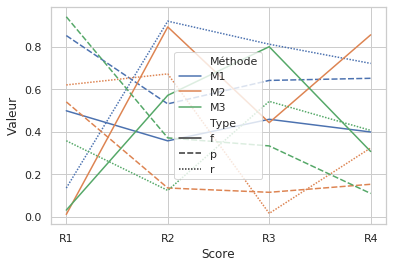

In [47]:
fmri = sns.load_dataset("fmri")
data = pd.DataFrame(columns = ["Méthode","Score","Type", "Valeur"])
rows = [] 
for m in dic :
    for s in dic[m] :
        for t in dic[m][s] :
            rows.append({"Méthode" : m, "Score" : s, "Type" : t, "Valeur" : dic[m][s][t]})
data = pd.DataFrame(rows, columns = ["Méthode","Score","Type", "Valeur"])


sns.lineplot(data=data, x="Score", y="Valeur",hue="Méthode", style ='Type' )
data, fmri